In [112]:
import numpy as np
import pandas as pd
import pickle
import json
import os
import logging
import datetime

from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
# evaluate multioutput regressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# import plt from matplotlib
import matplotlib.pyplot as plt

LOGGER = logging.getLogger(__name__)


In [3]:
# define location for testing
location = "alipark"

In [126]:
def load_model(location):
    # define filename
    filename = '../../models/alicante_{}_GDB/model.pkl'.format(location)
    # load model
    loaded_model = pickle.load(open(filename, 'rb'))

    return loaded_model

def load_data(location):
    data_filename = '../../data/DataForModels/UnivariateValidation/{}.csv'.format(location)
    df = pd.read_csv(data_filename, skiprows=3, index_col=5, parse_dates=True)

    # remove non-relevant columns from dataframe
    del df["Unnamed: 0"]
    del df["result"]
    del df["table"]
    del df["_start"]
    del df["_stop"]
    del df["_field"]
    del df["_measurement"]

    # remove NaN values
    df = df.dropna()

    # interpolate NaN values in pandas dataframe
    df = df.interpolate(method='linear', limit_direction='both', axis=0)

    return df

def load_feature_vectors(location):
    feature_vectors_filename = '../../data/DataForModels/UnivariateValidation/features_{}.json'.format(location)
    with open(feature_vectors_filename) as f:
        data = pd.DataFrame(json.loads(line) for line in f)

    # convert timestamp in seconds to datetime
    data['time'] = pd.to_datetime(data['timestamp'], unit='ms')
    del data['timestamp']

    # set time as index
    data.set_index('time', inplace=True)

    # remove records until 2022-10-24 00:00:00
    data = data.loc['2022-10-24 15:30:00':]

    return data

def get_target_vector(data, timestamp):
    # get target vector
    target_vector = data.loc[timestamp].values

    return target_vector 

def get_feature_vector(fv, n):
    # get feature vector
    feature_vector = fv.iloc[n].values[0]
 
    # get timestamp from index
    ts = fv.index[n]

    # get unix timestamp from Timestamp
    unix_ts = ts.timestamp()

    # append values to feature vector
    # create date-time from unix timestamp
    date_time = datetime.datetime.fromtimestamp(unix_ts)

    # add hour and day data to the feature vector
    feature_vector = np.append(feature_vector, date_time.hour)
    feature_vector = np.append(feature_vector, date_time.weekday())

    return ts, feature_vector

def get_target_vector(data, ts):
    # find first timestamp equal or greater than ts
    idx = data.index.get_loc(ts, method='ffill')
    ts = data.index[idx]

    vector = []
    for i in range(1, 384):
        vector.append(data.iloc[idx + i].values[0])    

    return idx, ts, vector

def model_predict(model, values):
    # make a prediction
    yhat = model.predict(values)

    return yhat[0]

In [90]:
# loading model, data and feature vectors
model = load_model(location)
data = load_data(location)
fv = load_feature_vectors(location)

# Daily predictions for the Location

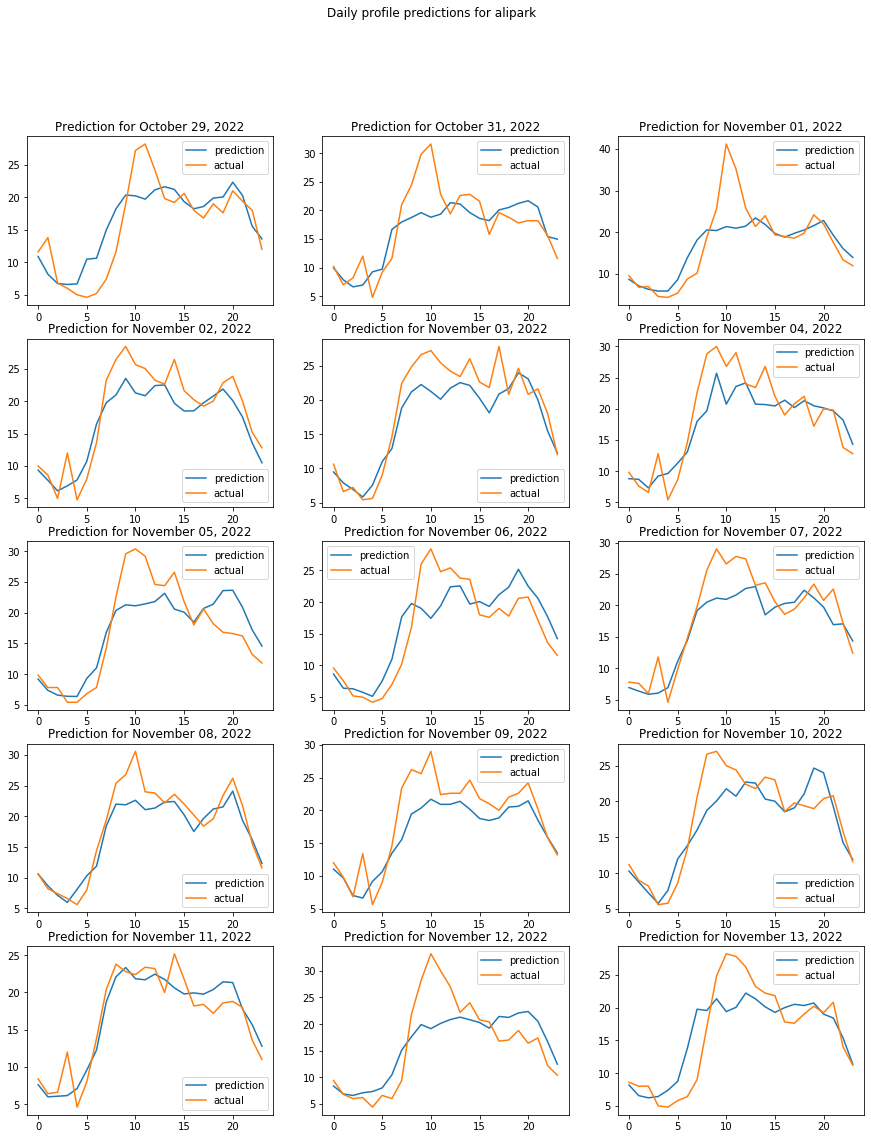

In [155]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def get_data_for_plot(fv, data, start, iter):
    ts, values = get_feature_vector(fv, start + iter)
    _, tsp, y = get_target_vector(data, ts)
    y_pred = model_predict(model, [values])

    return tsp, y, y_pred


# show matplotlib in vscode
# %%

# plot 3x3 plots
fig, axs = plt.subplots(5, 3, figsize=(15, 18))
fig.suptitle('Hourly profile predictions for {}'.format(location))

# plot predictions
for i in range(5):
    for j in range(3):
        tsp, y, y_pred = get_data_for_plot(fv, data, 493 - 5*48, (3*i+j)*48)
        axs[i, j].plot(y_pred[:48:2], label='prediction')
        axs[i, j].plot(y[:48:2], label='actual')
        axs[i, j].set_title('Prediction for {:%B %d, %Y}'.format(tsp))
        axs[i, j].legend()


#plt.plot(y_pred[:48:2], label="Predicted")
#plt.plot(y[:48:2], label="Actual")
#plt.legend()
plt.show()

# Daily predictions for the location

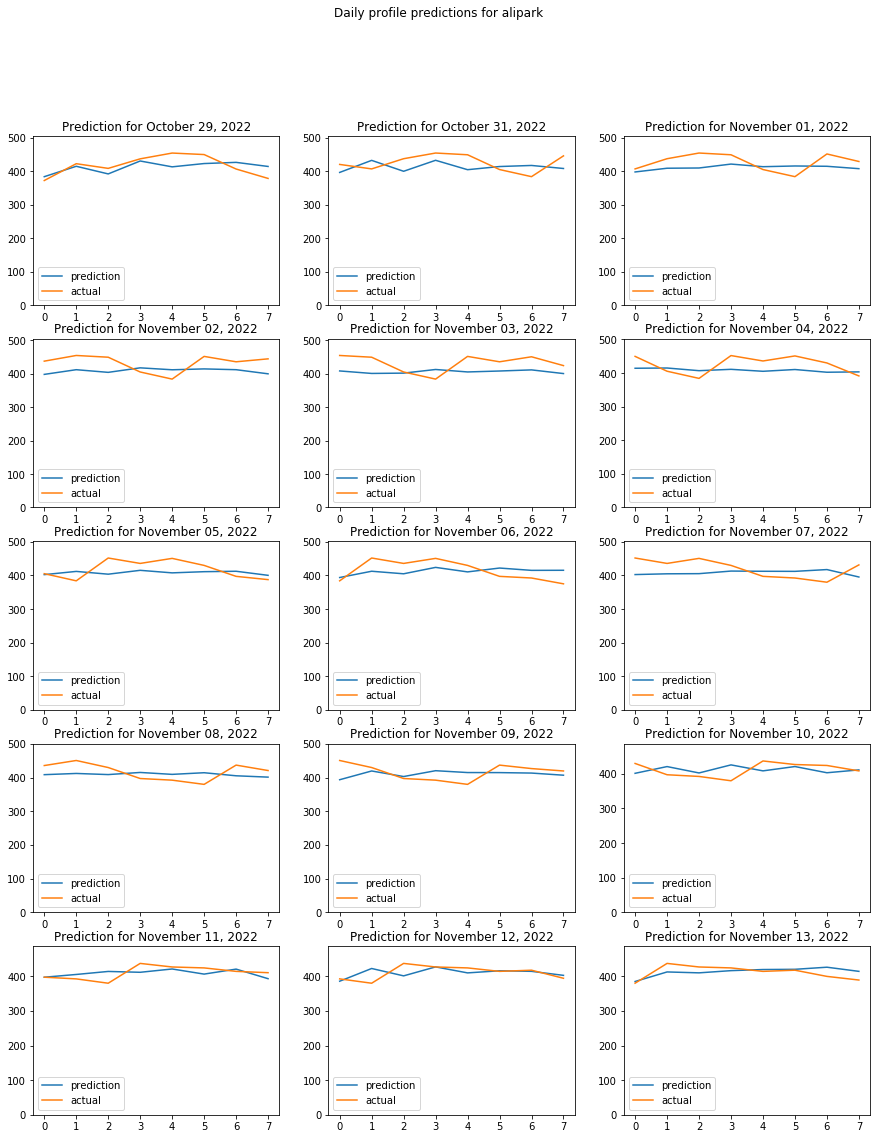

In [160]:
def get_daily_aggregates(y, y_pred):
    # each day is represented with 48 values
    # each value is 30 minutes

    y_daily = []
    y_pred_daily = []

    for i in range(0, len(y), 48):
        y_daily.append(sum(y[i:i+48]) / 2)
        y_pred_daily.append(sum(y_pred[i:i+48]) / 2)

    return y_daily, y_pred_daily


# plot 5x3 plots
fig, axs = plt.subplots(5, 3, figsize=(15, 18))
fig.suptitle('Daily profile predictions for {}'.format(location))

# plot predictions
for i in range(5):
    for j in range(3):
        tsp, y, y_pred = get_data_for_plot(fv, data, 493 - 5*48, (3*i+j)*48)
        y, y_pred = get_daily_aggregates(y, y_pred)
        # y axis between zero and max
        axs[i, j].set_ylim(0, max(y) + 50)
        axs[i, j].plot(y_pred, label='prediction')
        axs[i, j].plot(y, label='actual')
        axs[i, j].set_title('Prediction for {:%B %d, %Y}'.format(tsp))
        axs[i, j].legend()


#plt.plot(y_pred[:48:2], label="Predicted")
#plt.plot(y[:48:2], label="Actual")
#plt.legend()
plt.show()

In [158]:
y

[372.0,
 422.3,
 408.29999999999995,
 436.8000000000001,
 454.0999999999999,
 449.5999999999999,
 406.40000000000003,
 378.30000000000007]